In [52]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.constants import Planck, speed_of_light
from scipy.io import loadmat
import os
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl

Make sure that your data is in the correct format - you will need to have folders saved as 'currentmA_shorttime_longtime', with files inside labelled as: [short_in, long_in, short_out, long_out, bckg, long_bckg, empty, long_empty]. I will update this in future to generalise!

**Input paths to your data here 🔽**

In [2]:
# This is all stuff for you to change!
################################################################################################

# add the paths to your data and the calibration file and power conversion csv (normally found on the X drive)

dir_1 = r'G:\My Drive\Data\sample1'
dir_2 = r'G:\My Drive\Data\sample2'
dir_3 = r'G:\My Drive\Data\sample3'
dir_4 = r'G:\My Drive\Data\sample4'

dir_list = [dir_1, dir_2, dir_3, dir_4]

cal = np.loadtxt(r'G:\My Drive\Data\PLQY\2024-08-02_PLQYCalibrationfile2.txt')[:,1]
powers = pd.read_csv(r'G:\My Drive\Data\PLQY\csv_powers.csv', encoding='ISO-8859-1') # make sure this is a csv file, not xlsx

# these are the default settings, but you can toggle them at your peril
used_long_int = 1
laser_range = [395, 415]
pl_range = [560, 850]
stray_light=1

In [20]:
# analysis code to extract PLQY values from each set of measurements. This is pretty much the same as the normal PLQY code on the X Drive, 
# but I've refactored it so that we are working with dataframes rather than lists

def get_PLQY(data, short_time, long_time, cal, laser_range, pl_range, stray_light=False):
    """
    Processes the data and calculates PLQE, absorptance, etc.
    """
    # Extract data from dictionary
    short_in = data['short_in']
    short_out = data['short_out']
    long_in = data['long_in']
    long_out = data['long_out']
    short_bckg = data['bckg']
    short_empty = data['empty']
    long_bckg = data['long_bckg']
    long_empty = data['long_empty']
    
    wl = short_in['Wavelength']
    wl=wl.to_numpy()

    # Background subtraction
    def subtract(file, bckg):
        file['Intensity'] -= bckg['Intensity']
        return file

    subtract(short_in, short_bckg)
    subtract(short_out, short_bckg)
    subtract(short_empty, short_bckg)
    subtract(long_in, long_bckg)
    subtract(long_out, long_bckg)
    subtract(long_empty, long_bckg)

    # Scaling by integration time
    def scale(file, time):
        file['Intensity'] = file['Intensity'] / time
        return file

    scale(short_in, short_time)
    scale(short_out, short_time)
    scale(short_empty, short_time)
    scale(long_in, long_time)
    scale(long_out, long_time)
    scale(long_empty, long_time)

    # Combine short and long data
    def repl(short_, long_, wl, laser_range):
        low = np.max(np.argwhere(wl < laser_range[0]))
        high = np.min(np.argwhere(wl > laser_range[1]))
        combined = np.append(list(long_['Intensity'][0:low + 1]), list(short_['Intensity'][(low + 1):(high + 1)]))
        combined = np.append(combined, list(long_['Intensity'][(high + 1):]))
        return combined

    _in = repl(short_in, long_in, wl, laser_range)
    _out = repl(short_out, long_out, wl, laser_range)
    _empty = repl(short_empty, long_empty, wl, laser_range)

    # Apply calibration (generates spectra in µW/nm)
    _in *= cal
    _out *= cal
    _empty *= cal
    # put this back and put cal back into args for functions

    # Photon to energy conversion (J/photon)
    p2e = Planck * speed_of_light / (1e-9 * wl)

    # Integrals over given ranges
    def inte(d, x, _range):
        d_int = np.trapz(d[np.where((x > _range[0]) & (x < _range[1]))],
                         x=x[np.where((x > _range[0]) & (x < _range[1]))])
        return d_int

    def remove_stray(_in, _out, _empty, wl, wl_range, pl_range):
        def get_avg(x, wl, wl_range):
            idx = [np.argmin(abs(wl - wl_range[0])), np.argmin(abs(wl - wl_range[1]))]
            avg = np.trapz(x[idx[0]:idx[1]], wl[idx[0]:idx[1]])
            return avg

        avg_empty = get_avg(_empty, wl, wl_range)
        avg_out = get_avg(_out, wl, wl_range)
        avg_in = get_avg(_in, wl, wl_range)

        def corr_pl_range(d, x, _empty, avg_data, avg_empty, _range):
            d_pl_range = d[np.where((x > _range[0]) & (x < _range[1]))]
            _empty_pl_range = _empty[np.where((x > _range[0]) & (x < _range[1]))]
            d_corr = (d_pl_range * (avg_empty / avg_data) - _empty_pl_range) * (avg_data / avg_empty)
            d[np.where((x > _range[0]) & (x < _range[1]))] = d_corr
            return d

        _in = corr_pl_range(_in, wl, _empty, avg_in, avg_empty, pl_range)
        _out = corr_pl_range(_out, wl, _empty, avg_out, avg_empty, pl_range)
        _empty = corr_pl_range(_empty, wl, _empty, avg_empty, avg_empty, pl_range)

        return _in, _out, _empty

    if stray_light == True:
        wl_range = [370, 390]
        _in, _out, _empty = remove_stray(_in, _out, _empty, wl, wl_range, pl_range)

    # Calculate PLQE and absorptance
    absorbed_full = 1 - inte(_in / p2e, wl, laser_range) / inte(_out / p2e, wl, laser_range)
    PL_full = inte(_in / p2e, wl, pl_range) - inte(_empty / p2e, wl, pl_range) - (1 - absorbed_full) * (
                inte(_out / p2e, wl, pl_range) - inte(_empty / p2e, wl, pl_range))
    QE_full = PL_full / (inte(_empty / p2e, wl, laser_range) * absorbed_full)

    # Prepare results in a dictionary
    results = {'PLQY' : QE_full * 100, 'Absorptance' : absorbed_full * 100}
    spectra = _in - _empty



    return results, spectra, wl

In [105]:
# this function takes your root directory and loops the analysis code through the folders for each power measurement, spitting out 
# a nice dictionary at the end with PLQY values (and absorptance, so you can plot this if you want too)

def process_folders(root_directory):

    data = {}
    spectras = pd.DataFrame()
    
    # Loop through all folders in the root directory
    for folder_name in os.listdir(root_directory):
        folder_path = os.path.join(root_directory, folder_name)
        
        # Only process if it's a folder
        if os.path.isdir(folder_path):
            # Extract current, short time, and long time from folder name
            match = re.search(r'(\d+)mA_short(\d+)_long(\d+)', folder_name)
            if match != None:
                current = match.group(1)
                long_time = int(match.group(3))
                short_time = int(match.group(2))


                # Dictionary to hold file names and their content
                files = {}
                
                # Read each file in the folder and store their content
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    if os.path.isfile(file_path):
                        try:
                            test_data = pd.read_csv(file_path, sep='\t', header=12)
                            test_data = test_data.reset_index(drop = False)
                            test_data = test_data.rename(columns={'index' : 'Wavelength', '>>>>>Begin Spectral Data<<<<<' : 'Intensity'})
                            files[file_name.split('.')[0]] = test_data
                        except Exception as e:
                            print(f"Error reading {file_name}: {e}")
                            files[file_name.split('.')[0]] = pd.DataFrame()  # Empty dataframe in case of error
                        
                    else:
            # Default empty dataframe if the file is missing
                        data[file.split('.')[0]] = pd.DataFrame()
                        
            dict, spectra, wl = get_PLQY(files, short_time, long_time, cal, laser_range, pl_range, stray_light=True)
            data[current] = [dict['PLQY'], dict['Absorptance']]



            # convert into dataframe
            results_df = pd.DataFrame()

            spectras[current] = spectra

            currents = [int(key) for key in data.keys()]
            results_df['Current (mA)'] = currents
            plqys = [list(data.values())[i][0] for i in range(0, len(list(data.keys())))]
            results_df['PLQY'] = plqys
            abss = [list(data.values())[i][1] for i in range(0, len(list(data.keys())))]
            results_df['Absorptance'] = abss


            

            
            ## converting to photon flux
            laser_p2e = Planck * speed_of_light / (405*1e-9)

            for current in results_df['Current (mA)']:

                indi = powers.loc[(powers == current).any(axis=1)].index[0]
                pwr = powers.iloc[indi].iloc[2]

                i = results_df.loc[(results_df == current).any(axis=1)].index[0]
                results_df.loc[i, 'Power (mW/cm2)'] = pwr
    

            results_df['Photon Flux (e18 photons/s)'] = results_df['Power (mW/cm2)'] / (laser_p2e*1e21)
            spectras['Wavelength (nm)'] = wl

            # spectras = spectras[spectras['Wavelength (nm)'].between(500, 900)]
    
    
    return results_df, spectras





In [73]:
## just some functions to make prety colour gradients for plotting using colourmaps - feel free to skip this and just use standard colourmaps, eg viridis

def hex_to_RGB(hex_str):
    
    """ #FFFFFF -> [255,255,255]"""
    
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):

    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


colors=[]
c1='#805b87'
c2='#99c5c4'

colors=get_color_gradient(c1,c2,11)


**Update this cell with the names for each sample 🔽**

In [129]:
# running the code!

## the inputs here are specifically if you have multiple samples so that you can create a subplot with all of the plots together ##

results = [process_folders(directory)[0] for directory in dir_list]
spectralist = [process_folders(directory)[1] for directory in dir_list]

names = ['    Sample 1', '    Sample 2', '    Sample 3', '    Sample 4'] ## change to a list of names corresponding to you samples - make sure they are in the right order


**🔽 Plotting PLQY against Laser Power - this outputs a figure with four subplots - if you have more / less samples just update the first line - e.g, fig, axes = plt.subplots(2, 3, sharey = True, figsize = (10, 8)) for 2 rows and 3 columns**

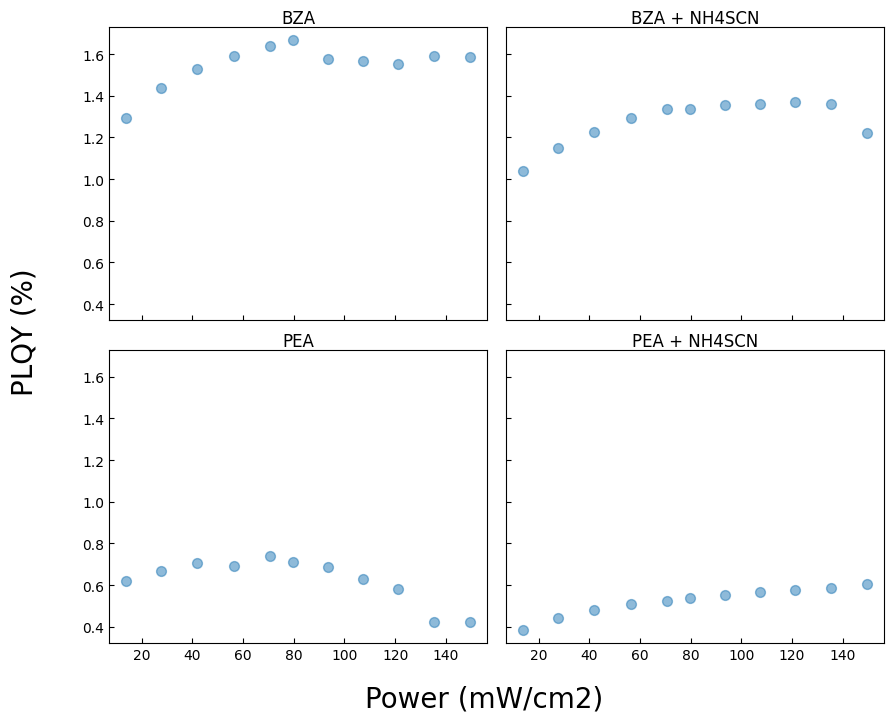

In [124]:
## plotting - mess around with this however much you like. The dataframe 'results' contains the PLQY, absorptance, current, laser power (mW/cm2)
## and photon flux, so plot whichever of these you like by changing 'x = ___' or 'y = ___' in the first line

# make sure to check that the length of your results list matches up with the number of subplots

fig, axes = plt.subplots(2, 2, sharey = True, figsize = (10, 8))
## this outputs a 2x2 subplot - change if you want more/less rows or columns ##

axes = axes.flatten()


for i, result in enumerate(results):
    
    axes[i].scatter(result['Power (mW/cm2)'], result['PLQY'], marker = 'o', alpha = 0.5, s = 50)
    axes[i].tick_params(direction = 'in')
    axes[i].set_title(names[i], loc='center', pad=-30)
    if i < 2:
        axes[i].set_xticklabels([])

fig.text(0.5, 0.04, 'Power (mW/cm2)', ha='center', va='center', fontsize = 20) 
fig.text(0.04, 0.5, 'PLQY (%)', ha='center', va='center', rotation='vertical', fontsize = 20) 
plt.subplots_adjust(hspace=0.1, wspace=0.05)



plt.savefig(r'G:\My Drive\Data\PLQY\25-02-04_ST042_ID_retest_FPEA_FBZA_NH4SCN\plots')
## change to the directory that you want to save into ##

**Plotting spectras with colourmap 🔽**

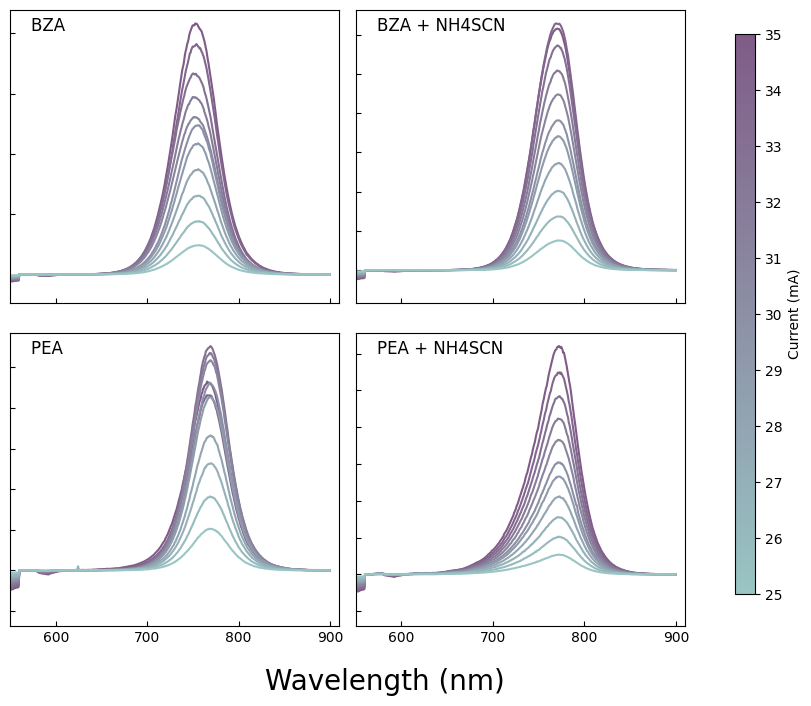

In [130]:
## spectras subplot ##

# make sure to check that the length of your results list matches up with the number of subplots


fig, axes = plt.subplots(2, 2, sharey = False, figsize = (10, 8))
## this outputs a 2x2 subplot - change if you want more/less rows or columns ##

axes = axes.flatten()


for i, spectras in enumerate(spectralist):

    spectras = spectras[spectras['Wavelength (nm)'].between(500, 900)]
    
    
    currents = list(spectras.columns.values)
    currents.remove('Wavelength (nm)')
    ax =axes[i]

    for j, current in enumerate(currents):
        spectras.plot(x='Wavelength (nm)', y=current, color=colors[j], ax=ax)
        ax.set_xlim(550, 910)
        ax.set_xlabel('')
        ax.tick_params(direction = 'in')
    ax.set_title(names[i], loc='left', y=0.9)
    ax.get_legend().remove()
    ax.set_yticklabels([])
    if i < 2:
        ax.set_xticklabels([])


fig.text(0.5, 0.04, 'Wavelength (nm)', ha='center', va='center', fontsize = 20) 
plt.subplots_adjust(hspace=0.1, wspace=0.05)


cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors).reversed()
norm = mpl.colors.Normalize(vmax=35, vmin=25)

    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Current (mA)', cax = cbar_ax, fraction = 0.5)
cbar.set_ticks(list(range(25,36)))



plt.savefig(r'G:\My Drive\Data\PLQY\25-02-04_ST042_ID_retest_FPEA_FBZA_NH4SCN\spectraplots')
## change to the directory that you want to save into ##